In [7]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
from PIL import Image

## Task-1 手写数字识别

### Step-1 Prepare Dataset

In [2]:
# 设置批量大小
batch_size = 64

# 定义数据转换器：首先将图像转换为PyTorch张量，然后进行标准化处理
transform = transforms.Compose([
    transforms.ToTensor(),                      # 将PIL图像转换为PyTorch张量
    transforms.Normalize((0.1307,), (0.3081,))  # 使用平均值和标准差进行标准化处理
])

# 加载MNIST训练数据集，如果数据不存在则下载，并应用定义的转换器
train_dataset = datasets.MNIST(root='./dataset/mnist', train=True, transform=transform, download=True)
# 创建训练数据的加载器，以指定的批量大小和是否打乱数据顺序进行配置
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 加载MNIST测试数据集，同样应用转换器，如果数据不存在则下载
test_dataset = datasets.MNIST(root='./dataset/mnist', train=False, transform=transform, download=True)
# 创建测试数据的加载器，使用与训练数据不同的配置，例如不需要打乱数据顺序
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100.0%


Extracting ./dataset/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./dataset/mnist\MNIST\raw



100.0%


Extracting ./dataset/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./dataset/mnist\MNIST\raw



100.0%


Extracting ./dataset/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./dataset/mnist\MNIST\raw



100.0%

Extracting ./dataset/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./dataset/mnist\MNIST\raw



### Step-2 Define Model

In [3]:
class InceptionA(torch.nn.Module):
    """
    InceptionA模块，为深度神经网络中的一个结构单元，用于处理输入的图像数据。
    
    参数:
    - in_channels: int, 输入图像的通道数
    
    方法:
    - forward: 前向传播方法
    """
    def __init__(self, in_channels):
        """
        初始化InceptionA模块。
        
        参数:
        - in_channels: 输入图像的通道数。
        """
        super().__init__()

        # 1x1卷积分支
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)

        # 1x1卷积 -> 5x5卷积分支
        self.branch5x5_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)

        # 1x1卷积 -> 3x3卷积 -> 3x3卷积分支
        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)

        # 平均池化 -> 1x1卷积分支
        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        """
        定义InceptionA模块的前向传播过程。
        
        参数:
        - x: 输入图像的数据张量
        
        返回:
        - 经过不同分支处理后，通道数拼接后的图像数据张量。
        """
        # 1x1卷积分支的处理
        branch1x1 = self.branch1x1(x)

        # 5x5卷积分支的处理
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        # 3x3卷积分支的处理
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        # 平均池化分支的处理
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        # 将不同分支的处理结果按通道数拼接起来
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)
    
class Net(torch.nn.Module):
    """
    定义一个包含InceptionA模块的网络结构。
    
    方法:
    - forward: 前向传播方法
    """
    def __init__(self):
        """
        初始化网络结构。
        """
        super().__init__()
        # 第一层卷积
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        # 第二层卷积
        self.conv2 = torch.nn.Conv2d(88, 20, 5)

        # 第一个InceptionA模块
        self.incep1 = InceptionA(10)
        # 第二个InceptionA模块
        self.incep2 = InceptionA(20)

        # 最大池化层
        self.mp = torch.nn.MaxPool2d(2)
        # 全连接层
        self.fc = torch.nn.Linear(1408, 10)

    def forward(self, x):
        """
        定义网络的前向传播过程。
        
        参数:
        - x: 输入图像的数据张量
        
        返回:
        - 网络的预测结果。
        """
        in_size = x.size(0)
        # 第一层卷积和池化
        x = F.relu(self.mp(self.conv1(x)))
        # 第一个InceptionA模块
        x = self.incep1(x)
        # 第二层卷积和池化
        x = F.relu(self.mp(self.conv2(x)))
        # 第二个InceptionA模块
        x = self.incep2(x)
        # 展平向量
        x = x.view(in_size, -1)
        # 全连接层
        x = self.fc(x)
        return x

model = Net()

### Step-3 Define Loss and Optimizer

In [4]:
# 初始化损失函数
# torch.nn.CrossEntropyLoss()：交叉熵损失函数，常用于多分类任务的损失计算。该函数输入为模型预测的概率分布和真实标签，
# 输出为模型预测与真实标签之间的损失值。
criterion = torch.nn.CrossEntropyLoss()

# 初始化优化器
# torch.optim.SGD：随机梯度下降法（Stochastic Gradient Descent）优化器，是深度学习中最常用的优化器之一。
# 参数model.parameters()指定了需要优化的模型参数；
# lr=0.01：学习率，控制参数更新的速度；
# momentum=0.5：动量参数，用于加速梯度下降过程，减少收敛过程中的振荡。
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

### Step-4 Train the Model

In [5]:
# 根据是否支持CUDA，选择使用GPU或CPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(epoch: int):
    """
    对模型进行训练。
    
    参数:
    - epoch: int, 当前的训练周期。
    
    无返回值。
    """
    running_loss = 0.0  # 记录当前批次的损失总和
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)  # 将数据移动到指定设备
        optimizer.zero_grad()  # 清除上一次的梯度

        outputs = model(inputs)  # 通过模型获取输出
        loss = criterion(outputs, target)  # 计算损失
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数

        running_loss += loss.item()  # 累加当前批次损失
        if batch_idx % 100 == 99:  # 每100个批次打印一次损失
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0  # 重置累积损失

def test():
    """
    对模型进行测试，并计算在测试集上的准确率。
    
    返回值:
    - float, 测试集上的准确率。
    """
    correct = 0  # 记录正确预测的数量
    total = 0  # 记录总预测数量
    with torch.no_grad():  # 不计算梯度，以节省内存
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)  # 将数据移动到指定设备
            outputs = model(images)  # 通过模型获取输出
            _, predicted = torch.max(outputs.data, 1)  # 找出预测的类别
            total += labels.size(0)  # 累加总样本数
            correct += (predicted == labels).sum().item()  # 累加正确预测的数量
    print(f'Accuracy on test set: {100 * correct / total: .4f}%')
    return 100 * correct / total  # 返回准确率

[1,   100] loss: 1.901
[1,   200] loss: 0.582
[1,   300] loss: 0.380
[1,   400] loss: 0.314
[1,   500] loss: 0.267
[1,   600] loss: 0.235
[1,   700] loss: 0.188
[1,   800] loss: 0.175
[1,   900] loss: 0.144
Accuracy on test set:  96.1500%
[2,   100] loss: 0.135
[2,   200] loss: 0.120
[2,   300] loss: 0.115
[2,   400] loss: 0.120
[2,   500] loss: 0.097
[2,   600] loss: 0.118
[2,   700] loss: 0.103
[2,   800] loss: 0.093
[2,   900] loss: 0.090
Accuracy on test set:  97.5200%
[3,   100] loss: 0.086
[3,   200] loss: 0.082
[3,   300] loss: 0.090
[3,   400] loss: 0.082
[3,   500] loss: 0.073
[3,   600] loss: 0.080
[3,   700] loss: 0.079
[3,   800] loss: 0.070
[3,   900] loss: 0.063
Accuracy on test set:  98.0000%
[4,   100] loss: 0.064
[4,   200] loss: 0.067
[4,   300] loss: 0.070
[4,   400] loss: 0.068
[4,   500] loss: 0.056
[4,   600] loss: 0.065
[4,   700] loss: 0.067
[4,   800] loss: 0.067
[4,   900] loss: 0.065
Accuracy on test set:  98.5400%
[5,   100] loss: 0.055
[5,   200] loss: 0.06

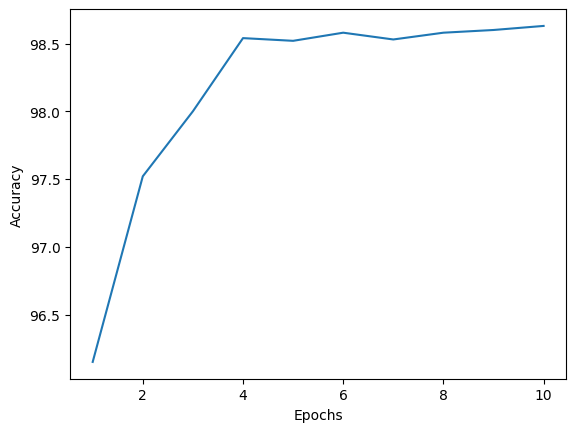

In [6]:
epochs = []
accuracies = []

if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        epochs.append(epoch + 1)
        accuracies.append(test())
    plt.plot(epochs, accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

### 检测模型

In [21]:
def test_model(model, test_dir, device):
    # Define the transformation for the test images
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST dataset
    ])

    # Create a directory iterator for the test images
    test_images = os.listdir(test_dir)

    # Set the model to evaluation mode
    model.eval()

    # Iterate over the test images
    for image_name in test_images:
        image_path = os.path.join(test_dir, image_name)
        image = Image.open(image_path).convert('L')  # Convert to grayscale

        # Apply the transformation
        image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

        # Move the input tensor to the device
        image_tensor = image_tensor.to(device)

        # Forward pass
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output.data, 1)

        # Display the image and predicted value
        plt.imshow(image, cmap='gray')
        plt.title(f'Predicted: {predicted.item()}')
        plt.show()

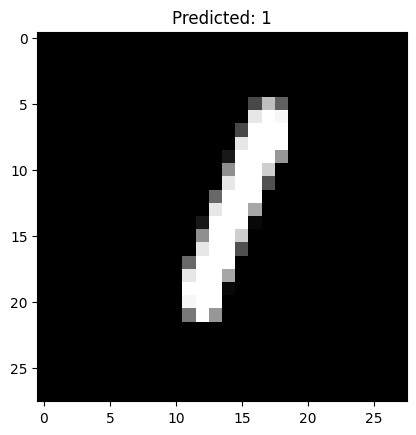

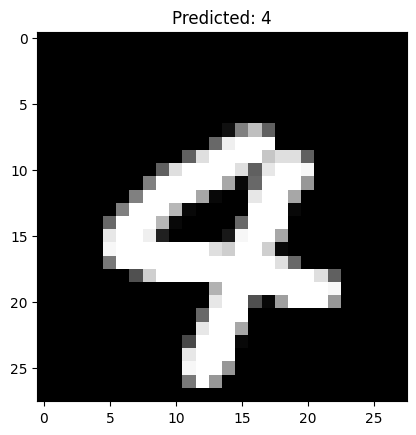

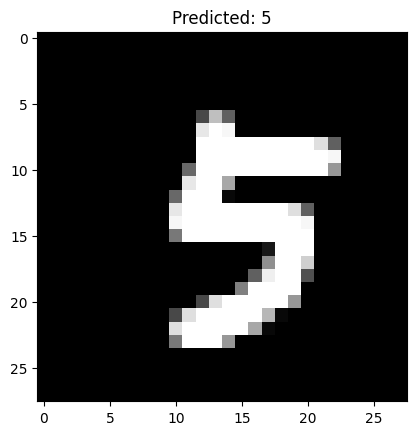

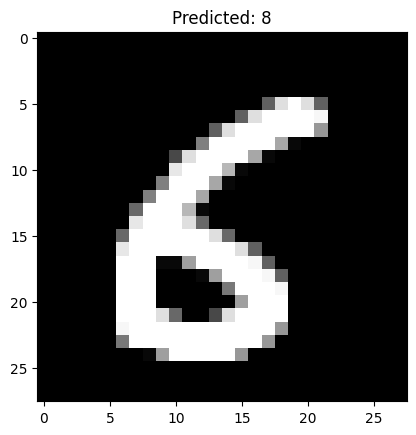

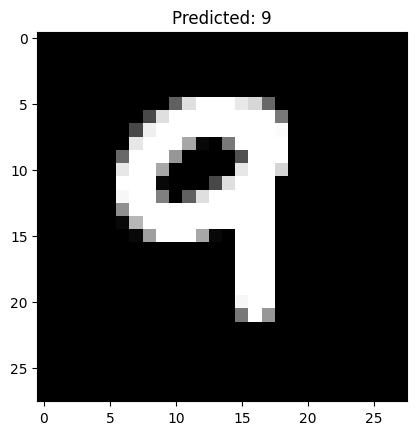

In [24]:
test_model(model, './test/mnist', device)